# Form Cropping

#### This process aims to crop and transform the forms into proper size and orientation for field detections

In [1]:
from __future__ import print_function
from imutils import perspective
from imutils import contours
from matplotlib import pyplot as plt
from PIL import Image
from skimage import io , img_as_float
from scipy.spatial import distance as dist

import argparse
import cv2
import numpy as np
import image_slicer
import imutils




### Corner detection algorithsm

In [2]:
def cornerDetect(Img):
    img = cv2.imread(Img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    corners = cv2.goodFeaturesToTrack(gray,maxCorners = 10000,qualityLevel=0.01,minDistance = 10,useHarrisDetector=True)
    corners = np.int0(corners)

    for i in corners:
        x,y = i.ravel()
        cv2.circle(img,(x,y),3,255,-1)
    cv2.imwrite('GFeature.png',img)
    plt.imshow(img),plt.show()

### Line detection Function

In [3]:
def lineDetectFun(Im):
    img = cv2.imread(Im)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,50,150,apertureSize = 3)
    minLineLength = 10
    maxLineGap = 50
    lines = cv2.HoughLinesP(edges,rho=1,theta=np.pi/180,threshold=100,minLineLength=minLineLength,maxLineGap=maxLineGap)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img,(x1,y1),(x2,y2),(255,255,255),2)

    cv2.imwrite('houghlines5.png',img)

### Loop over each contour for size

In [4]:
def findContours(img):
    
    image = cv2.imread(img)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY);
    #find major contours in the image
    cnts = cv2.findContours(image.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    (cnts, _) = contours.sort_contours(cnts)
    colors = ((0, 0, 255), (240, 0, 159), (255, 0, 0), (255, 255, 0))
    
    maxArea = -1
    boxFinal = []
    for (i, c) in enumerate(cnts):
        # if the contour is not sufficiently large, ignore it
        if cv2.contourArea(c) < maxArea:
            continue
        maxArea = cv2.contourArea(c)
        # compute the rotated bounding box of the contour, then
        # draw the contours
        box = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        cv2.imwrite("preDetect.jpg",image)
        image = cv2.drawContours(image, [box], -1, (255, 153, 255), 2)
       
        # show the original coordinates
        neg = False
        for it in box:
            if it[0] <0 or it[1] <0:
                neg = True
        
        if neg is True:
            continue
        
        print("Object #{}:".format(i + 1))
        print(box)
        boxFinal = box
        
    return boxFinal

### Edge detection Function

In [5]:
def edgeDetectFun(Images):
    imjpg = Image.open(Images)
    imjpg.save('Scanned Auto FNOL-2.png')
    
#     # find the average pixel value for the image
#     imageShade = io.imread('Scanned Auto FNOL-2.png')
#     imageShade = img_as_float(imageShade)
#     avgThrehold = np.mean(imageShade)
#     print(avgThrehold)

    img = cv2.imread('Scanned Auto FNOL-2.png')
    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    #img = cv2.morphologyEx(img, cv2.MORPH_OPEN, None)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, None)
    #img = cv2.morphologyEx(img, cv2.MORPH_OPEN, None)

    img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.adaptiveThreshold(img_grey,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,9)
    
    cv2.imwrite('bwimage.png',img)

    edges = cv2.Canny(img,10,20)
    #edges = cv2.dilate(edges, None, iterations=1)
    #edges = cv2.erode(edges, None, iterations=1)
    
    cv2.imwrite('edgeTest.png',edges)

    lineDetectFun('edgeTest.png')

    finalCoordinates = findContours('houghlines5.png')
    
    plt.subplot(121),plt.imshow(img,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
   

    plt.rcParams['figure.figsize'] = [200, 50]
    fig=plt.figure(figsize=(180, 160))
    
    #use the lineDetectorfun
    #edges = lineDetectFun('edgeTest.png')
    #edges = cv2.erode(edges, None, iterations=1)
    
    #find major contours in the image
  
    
    return finalCoordinates
    

## Processing Function

In [6]:
def mainProcessFun(filename):
    points = edgeDetectFun(filename)
    img = cv2.imread('bwimage.png')

    rows,cols,ch = img.shape

    # find the corresponding corners for the elements
    points = sorted(points,key=sum)
    print(points)

    tl = points[0]
    br = points[3]

    if points[1][0]>points[2][0]:
        tr = points[1]
        bl = points[2]
    elif points[1][0]<points[2][0]:
        tr = points[2]
        bl = points[1]
    elif points[1][1] > points[2][1] :
        # if for whatever reason, x value is the same, which is highly unlikely
        #compare y value
        tr = points[2]
        br = points[1]
    else:
        tr = points[1]
        br = points[2]


    pts1 = np.float32([tl,tr,bl,br])


    pts2 = np.float32([[0,0],[3000,0],[0,4000],[3000,4000]])

    M = cv2.getPerspectiveTransform(pts1, pts2)

    dst = cv2.warpPerspective(img, M, (3000,4000))
    # try to recover some of the lost lines in the image
    dst = cv2.erode(dst, None, iterations=2)


    plt.subplot(121),plt.imshow(img),plt.title('Input')
    plt.subplot(122),plt.imshow(dst),plt.title('Output')
    cv2.imwrite("finalResult.jpg",dst)
    plt.rcParams['figure.figsize'] = [200, 50]
    fig=plt.figure(figsize=(180, 160))

## Testing Functions

Object #1:
[[1194 3459]
 [ 226 1260]
 [1912  518]
 [2880 2717]]
[array([ 226, 1260]), array([1912,  518]), array([1194, 3459]), array([2880, 2717])]


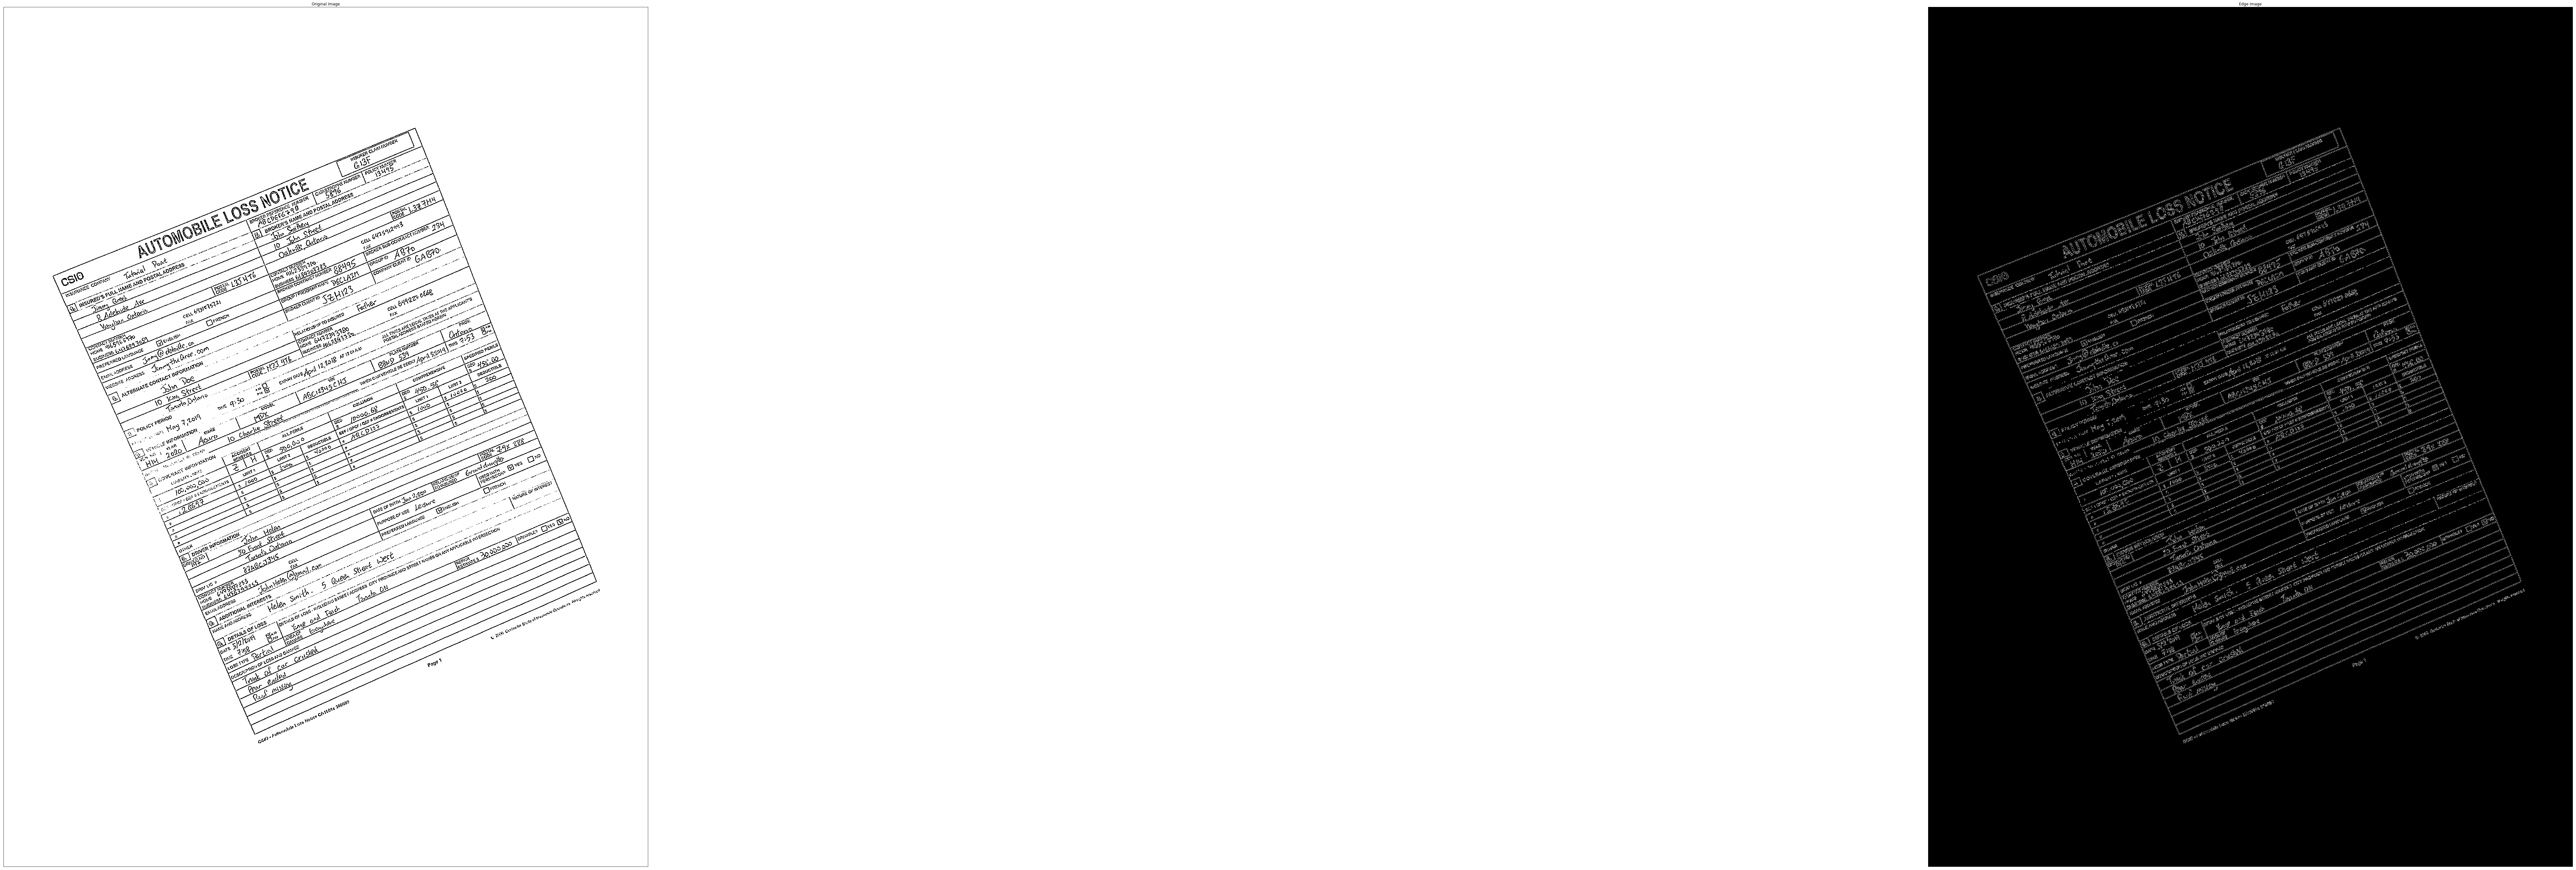

<Figure size 12960x11520 with 0 Axes>

In [8]:

mainProcessFun('2.jpg')
